# AML Assignment 3:
Aniket Santra(MDS202106)\
Avik Das(MDS202112)\
Meghna Mondal(MDS202123)

In [18]:
%matplotlib inline

In [19]:
!pip3 install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Calculating reward for the general Game

Run: 0 Average: 17.0 Min: 17 Max: 17
Run: 100 Average: 21.7 Min: 9 Max: 68
Run: 200 Average: 22.07 Min: 9 Max: 68
Run: 300 Average: 23.47 Min: 9 Max: 58
Run: 400 Average: 22.34 Min: 9 Max: 71
Run: 500 Average: 21.76 Min: 9 Max: 53
Run: 600 Average: 26.03 Min: 9 Max: 95
Run: 700 Average: 27.06 Min: 10 Max: 93
Run: 800 Average: 26.17 Min: 9 Max: 85
Run: 900 Average: 27.02 Min: 10 Max: 109
Run: 1000 Average: 27.41 Min: 10 Max: 80
Run: 1100 Average: 29.19 Min: 9 Max: 85
Run: 1200 Average: 31.62 Min: 10 Max: 95
Run: 1300 Average: 30.88 Min: 11 Max: 133
Run: 1400 Average: 33.46 Min: 10 Max: 99
Run: 1500 Average: 35.56 Min: 11 Max: 93
Run: 1600 Average: 37.57 Min: 10 Max: 141
Run: 1700 Average: 38.48 Min: 12 Max: 88
Run: 1800 Average: 41.18 Min: 11 Max: 116
Run: 1900 Average: 43.95 Min: 11 Max: 106
Run: 2000 Average: 47.8 Min: 12 Max: 160
Run: 2100 Average: 44.04 Min: 11 Max: 131
Run: 2200 Average: 54.89 Min: 9 Max: 203
Run: 2300 Average: 48.13 Min: 11 Max: 126
Run: 2400 Average: 52.48 Min: 1

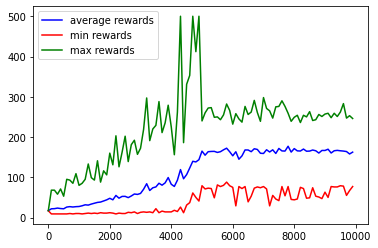

In [55]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import imageio
from IPython.display import HTML

env = gym.make('CartPole-v1')

# How much new info will override old info. 0 means nothing is learned, 1 means only most recent is considered, old knowledge is discarded
LEARNING_RATE = 0.1
# Between 0 and 1, mesue of how much we carre about future reward over immedate reward
DISCOUNT = 0.95
RUNS = 10000  # Number of iterations run
SHOW_EVERY = 2000  # How often the current solution is rendered
UPDATE_EVERY = 100  # How often the current progress is recorded

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = RUNS // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)


# Create bins and Q table
def create_bins_and_q_table():

  numBins = 20
  obsSpaceSize = len(env.observation_space.high)

  # Get the size of each bucket
  # Partitioning the intervals of Cartpole position & Pole angle double w.r.t. the velocities;
  # since they are more important for termination of the game.

  bins = [
    np.linspace(-4.8, 4.8, numBins*2),
    np.linspace(-4, 4, numBins),
    np.linspace(-.418, .418, numBins*2),
    np.linspace(-4, 4, numBins)
  ]

  qTable = np.random.uniform(low=0, high=0.000001, size=([numBins*2, numBins, numBins*2, numBins] + [env.action_space.n]))

  return bins, obsSpaceSize, qTable


# Given a state of the enviroment, return its descreteState index in qTable
def get_discrete_state(state, bins, obsSpaceSize):
	stateIndex = []
	for i in range(obsSpaceSize):
		stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
	return tuple(stateIndex)

bins, obsSpaceSize, qTable = create_bins_and_q_table()

previousCnt = []  # array of all scores over runs
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph

for run in range(RUNS):
  discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
  done = False  # has the enviroment finished?
  cnt = 0  # how may movements cart has made

  while not done:
    if run % SHOW_EVERY == 0:
      env.render()  # if running RL comment this out

    cnt += 1

    # Performing Exploration using epsilon-greedy policy
    # Get action from Q table
    if np.random.random() > epsilon:
      action = np.argmax(qTable[discreteState])
    # Get random action
    else:
      action = np.random.randint(0, env.action_space.n)
    newState, reward, done, _ = env.step(action)  # perform action on enviroment

    newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)

    maxFutureQ = np.max(qTable[newDiscreteState])  # estimate of optiomal future value
    currentQ = qTable[discreteState + (action, )]  # old value

    # formula to caculate all Q values
    newQ = (1 - LEARNING_RATE) * currentQ + LEARNING_RATE * (reward + DISCOUNT * maxFutureQ)
    qTable[discreteState + (action, )] = newQ  # Update qTable with new Q value

    discreteState = newDiscreteState

  previousCnt.append(cnt)

  # Decaying is being done every run if run number is within decaying range
  if END_EPSILON_DECAYING >= run >= START_EPSILON_DECAYING:
    epsilon -= epsilon_decay_value

  # Add new metrics for graph
  if run % UPDATE_EVERY == 0:
    latestRuns = previousCnt[-UPDATE_EVERY:]
    averageCnt = sum(latestRuns) / len(latestRuns)
    metrics['ep'].append(run)
    metrics['avg'].append(averageCnt)
    metrics['min'].append(min(latestRuns))
    metrics['max'].append(max(latestRuns))
    print("Run:", run, "Average:", averageCnt, "Min:", min(latestRuns), "Max:", max(latestRuns))

# print(qTable)
env.close()

# Plot graph
plt.plot(metrics['ep'], metrics['avg'], label="average rewards", color="blue")
plt.plot(metrics['ep'], metrics['min'], label="min rewards", color="red")
plt.plot(metrics['ep'], metrics['max'], label="max rewards", color="green")
plt.legend(loc=2)
plt.show()

###  Q-function of the optimal policy

In [56]:
qTable

array([[[[[7.69617681e-07, 6.64850696e-09],
          [6.97859093e-07, 6.27006568e-08],
          [4.79716015e-07, 4.92037407e-07],
          ...,
          [3.44998477e-07, 9.09473406e-07],
          [1.57741304e-07, 6.98932454e-08],
          [2.14529651e-07, 4.28428383e-07]],

         [[4.09957493e-07, 1.80640721e-07],
          [7.28000943e-07, 6.16988488e-07],
          [8.96807545e-08, 3.43011802e-07],
          ...,
          [3.43258667e-07, 8.41810934e-07],
          [1.25372607e-07, 5.62020481e-07],
          [5.08866578e-07, 2.74548172e-07]],

         [[3.39455645e-07, 5.39980312e-07],
          [6.32334302e-07, 5.64056961e-07],
          [1.00917211e-07, 9.38748429e-07],
          ...,
          [1.38000349e-07, 2.75615865e-07],
          [5.86905858e-07, 9.32182048e-07],
          [7.29981294e-07, 8.55784411e-07]],

         ...,

         [[8.86948846e-08, 7.37472353e-07],
          [5.37844398e-08, 8.95256763e-07],
          [3.03375924e-07, 6.49913206e-07],
          

## Playing the new version of the game, where the reward is 0 for every time step. But, if the pole angle is the range (-12, -6) or (6, 12), then there is a reward of +2.

Run: 0 Average_moves: 26.0 Min_moves: 26 Max_moves: 26 	 Average_rewards: 12.0 Min_rewards: 12 Max_rewards: 12
Run: 100 Average_moves: 21.58 Min_moves: 8 Max_moves: 66 	 Average_rewards: 11.74 Min_rewards: 4 Max_rewards: 52
Run: 200 Average_moves: 19.41 Min_moves: 9 Max_moves: 50 	 Average_rewards: 11.58 Min_rewards: 4 Max_rewards: 38
Run: 300 Average_moves: 22.56 Min_moves: 8 Max_moves: 70 	 Average_rewards: 13.1 Min_rewards: 4 Max_rewards: 82
Run: 400 Average_moves: 19.86 Min_moves: 9 Max_moves: 52 	 Average_rewards: 10.44 Min_rewards: 4 Max_rewards: 30
Run: 500 Average_moves: 20.11 Min_moves: 8 Max_moves: 64 	 Average_rewards: 12.26 Min_rewards: 4 Max_rewards: 54
Run: 600 Average_moves: 20.66 Min_moves: 9 Max_moves: 49 	 Average_rewards: 12.6 Min_rewards: 6 Max_rewards: 56
Run: 700 Average_moves: 21.41 Min_moves: 9 Max_moves: 60 	 Average_rewards: 13.58 Min_rewards: 4 Max_rewards: 68
Run: 800 Average_moves: 19.89 Min_moves: 9 Max_moves: 55 	 Average_rewards: 11.28 Min_rewards: 4 Max

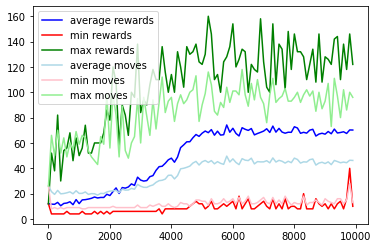

In [57]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import imageio
from IPython.display import HTML

env = gym.make('CartPole-v1')

# How much new info will override old info. 0 means nothing is learned, 1 means only most recent is considered, old knowledge is discarded
LEARNING_RATE = 0.1
# Between 0 and 1, mesue of how much we carre about future reward over immedate reward
DISCOUNT = 0.95
RUNS = 10000  # Number of iterations run
SHOW_EVERY = 2000  # How often the current solution is rendered
UPDATE_EVERY = 100  # How often the current progress is recorded

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = RUNS // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)

# Create bins and Q table
def create_bins_and_q_table():

  numBins = 20
  obsSpaceSize = len(env.observation_space.high)

  # Get the size of each bucket
  # Partitioning the intervals of Cartpole position twice & Pole angle thrice w.r.t. the velocities;
  # since they are more important for termination of the game and for getting positive reward.

  bins = [
    np.linspace(-4.8, 4.8, numBins*2),
    np.linspace(-4, 4, numBins),
    np.linspace(-.418, .418, numBins*3),
    np.linspace(-4, 4, numBins)
  ]

  qTable = np.random.uniform(low=0, high=0.000001, size=([numBins*2, numBins, numBins*3, numBins] + [env.action_space.n]))

  return bins, obsSpaceSize, qTable


# Given a state of the enviroment, return its descreteState index in qTable
def get_discrete_state(state, bins, obsSpaceSize):
	stateIndex = []
	for i in range(obsSpaceSize):
		stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
	return tuple(stateIndex)

bins, obsSpaceSize, qTable = create_bins_and_q_table()

previousCnt = []  # array of all scores over runs
previousReward = []
metrics = {'ep': [], 'avg_reward': [], 'min_reward': [], 'max_reward': [], 'min_moves': [], 'max_moves': [], 'avg_moves': []}  # metrics recorded for graph

for run in range(RUNS):
  discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
  done = False  # has the enviroment finished?
  cnt = 0  # how may movements cart has made
  R = 0 # how much reward gained in the game
  while not done:
    if run % SHOW_EVERY == 0:
      env.render()  # if running RL comment this out

    # Performing Exploration using epsilon-greedy policy
    # Get action from Q table
    if np.random.random() > epsilon:
      action = np.argmax(qTable[discreteState])
    # Get random action
    else:
      action = np.random.randint(0, env.action_space.n)
    newState, reward, done, _ = env.step(action)  # perform action on enviroment

    if -.418/2 <= newState[2] <= -.418/4 or .418/2 >= newState[2] >= .418/4:
      reward = 2
    else:
      reward = 0

    newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)

    maxFutureQ = np.max(qTable[newDiscreteState])  # estimate of optiomal future value
    currentQ = qTable[discreteState + (action, )]  # old value

    # formula to caculate all Q values
    newQ = (1 - LEARNING_RATE) * currentQ + LEARNING_RATE * (reward + DISCOUNT * maxFutureQ)
    qTable[discreteState + (action, )] = newQ  # Update qTable with new Q value

    discreteState = newDiscreteState

    cnt += 1
    R += reward

  previousCnt.append(cnt)
  previousReward.append(R)

  # Decaying is being done every run if run number is within decaying range
  if END_EPSILON_DECAYING >= run >= START_EPSILON_DECAYING:
    if epsilon - epsilon_decay_value > 0:
      epsilon -= epsilon_decay_value

  # Add new metrics for graph
  if run % UPDATE_EVERY == 0:
    latestRuns = previousCnt[-UPDATE_EVERY:]
    latestRewards = previousReward[-UPDATE_EVERY:]
    averageCnt = sum(latestRuns) / len(latestRuns)
    averageReward = sum(latestRewards) / len(latestRewards)
    metrics['ep'].append(run)
    metrics['avg_moves'].append(averageCnt)
    metrics['min_moves'].append(min(latestRuns))
    metrics['max_moves'].append(max(latestRuns))
    metrics['avg_reward'].append(averageReward)
    metrics['min_reward'].append(min(latestRewards))
    metrics['max_reward'].append(max(latestRewards))
    print("Run:", run, "Average_moves:", averageCnt, "Min_moves:", min(latestRuns), "Max_moves:", max(latestRuns), "\t Average_rewards:", averageReward, "Min_rewards:", min(latestRewards), "Max_rewards:", max(latestRewards))

# print(qTable)
env.close()

# Plot graph
plt.plot(metrics['ep'], metrics['avg_reward'], label="average rewards", color="blue")
plt.plot(metrics['ep'], metrics['min_reward'], label="min rewards", color="red")
plt.plot(metrics['ep'], metrics['max_reward'], label="max rewards", color="green")
plt.plot(metrics['ep'], metrics['avg_moves'], label="average moves", color="lightblue")
plt.plot(metrics['ep'], metrics['min_moves'], label="min moves", color="pink")
plt.plot(metrics['ep'], metrics['max_moves'], label="max moves", color="lightgreen")
plt.legend(loc=2)
plt.show()

###  Q-function of the optimal policy

In [58]:
qTable

array([[[[[6.01679152e-07, 9.76358941e-07],
          [5.63896715e-07, 5.11450428e-07],
          [5.38610821e-07, 9.69445171e-07],
          ...,
          [1.23034559e-07, 5.61102876e-07],
          [9.91256466e-07, 1.36490691e-07],
          [3.42603201e-07, 8.50515474e-07]],

         [[4.36459970e-07, 5.43506736e-07],
          [3.35259585e-07, 7.47350966e-07],
          [7.91245615e-07, 6.09781021e-07],
          ...,
          [1.70506544e-07, 8.98308408e-08],
          [5.54296268e-07, 2.20788344e-07],
          [5.85441699e-07, 5.49719085e-08]],

         [[5.23475053e-07, 3.30963343e-07],
          [1.86385788e-07, 7.95295959e-07],
          [5.89145439e-07, 5.11605768e-07],
          ...,
          [3.29995242e-08, 1.79027923e-07],
          [1.08143096e-07, 9.24542976e-07],
          [4.91787069e-07, 9.34293338e-07]],

         ...,

         [[3.64385085e-08, 6.57179320e-07],
          [4.00977999e-07, 6.47612143e-08],
          [4.27391663e-07, 1.52354878e-08],
          